# Limpeza do Dataset

Treinar o modelo usando o knn:
    - fazer a regressão linear 
    - árvores de decisão 
    - Random Forest e variantes (e.g., XGBoost)
    - Support Vector Machines (SVM)
    - Redes Neuronais

features (x) - colunas de 0 a 11 
target (price, y) - coluna 12 

In [ ]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error
from matplotlib.ticker import FuncFormatter
from sklearn.svm import SVR
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor



In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
### ----------------TRAIN------------------------------------------------------
train['horsepower'] = train['engine'].str.extract('(\d+\.?\d*)HP').astype(float)
train['displacement'] = train['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
train['cylinders'] = train['engine'].str.extract(r'(\d+)\s*Cylinder').astype(float)

no_engine = (train['horsepower'].isnull() & train['horsepower'].isnull() & train['horsepower'].isnull())
train['eletric'] = np.where(no_engine, 1,0)
train.drop(columns= ['engine'], inplace=True)

### ----------------TESTE------------------------------------------------------
test['horsepower'] = test['engine'].str.extract('(\d+\.?\d*)HP').astype(float)
test['displacement'] = test['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
test['cylinders'] = test['engine'].str.extract(r'(\d+)\s*Cylinder').astype(float)
test['fuel_type'] = test['fuel_type'].replace('not supported', 'unknown')

no_engine = (test['horsepower'].isnull() & test['displacement'].isnull() & test['cylinders'].isnull())
test['eletric'] = np.where(no_engine, 1, 0)
test.drop(columns=['engine'], inplace=True)



<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\thleal\AppData\Local\Temp\ipykernel_25080\969259585.py:2: SyntaxWarning: invalid escape sequence '\d'
  train['horsepower'] = train['engine'].str.extract('(\d+\.?\d*)HP').astype(float)
C:\Users\thleal\AppData\Local\Temp\ipykernel_25080\969259585.py:11: SyntaxWarning: invalid escape sequence '\d'
  test['horsepower'] = test['engine'].str.extract('(\d+\.?\d*)HP').astype(float)


In [4]:
### ----------------TRAIN------------------------------------------------------

train = train.fillna({'fuel_type': 'unknown', 'clean_title': 0, 'accident': 'unknown', 'horsepower': 0, 'displacement': 0, 'cylinders': 0})
replace_cols = ['fuel_type', 'ext_col', 'int_col']

for col in replace_cols:
    train[col] = train[col].replace({'–': 'unknown'})
    
### ----------------TEST------------------------------------------------------

test = test.fillna({'fuel_type': 'unknown', 'clean_title': 0, 'accident': 'unknown', 'horsepower': 0, 'displacement': 0, 'cylinders': 0})
    
for col in ['fuel_type', 'ext_col', 'int_col']:
    test[col] = test[col].replace({'–': 'unknown'})


In [5]:
accident = {
    'None reported': 0,
    'At least 1 accident or damage reported' : 1,
    'unknown' : 0
}

### ----------------TRAIN------------------------------------------------------
train['clean_title'] = train['clean_title'].astype('category')
train['clean_title'] = train['clean_title'].cat.codes

train['accident'] = train['accident'].map(accident)

### ----------------TEST------------------------------------------------------

test['clean_title'] = test['clean_title'].astype('category')
test['clean_title'] = test['clean_title'].cat.codes

test['accident'] = test['accident'].map(accident)



In [6]:
ohe_fuel = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

### ----------------TRAIN------------------------------------------------------
train['fuel_type'] = train['fuel_type'].astype('category')
fuel_ohe_train = ohe_fuel.fit_transform(train[['fuel_type']])
fuel_ohe_train_df = pd.DataFrame(fuel_ohe_train, 
                                 columns=ohe_fuel.get_feature_names_out(['fuel_type']),
                                 index=train.index)

train = pd.concat([train.drop(columns=['fuel_type']), fuel_ohe_train_df], axis=1)

### ----------------TEST------------------------------------------------------
test['fuel_type'] = test['fuel_type'].astype('category')
fuel_ohe_test = ohe_fuel.transform(test[['fuel_type']])
fuel_ohe_test_df = pd.DataFrame(fuel_ohe_test, 
                                columns=ohe_fuel.get_feature_names_out(['fuel_type']),
                                index=test.index)

test = pd.concat([test.drop(columns=['fuel_type']), fuel_ohe_test_df], axis=1)



In [7]:
train['transmission_type'] = train['transmission'].str.extract(
    r'(A/T|M/T|CVT|Auto-Shift|Dual Shift|Overdrive Switch|Automatic|Manual)'
)
train['transmission_speed'] = train['transmission'].str.extract('(\d+\.?\d*)-Speed').astype(float)
train = train.fillna({'transmission_speed': 0, 'transmission_type': 'unknown'})

train = train.drop('transmission', axis = 1)
 
# Extrair tipo de transmissão
test['transmission_type'] = test['transmission'].str.extract(
    r'(A/T|M/T|CVT|Auto-Shift|Dual Shift|Overdrive Switch|Automatic|Manual)'
)

#-----TEST----
# Extrair velocidade (pode não existir → vira NaN e depois tratamos)
test['transmission_speed'] = test['transmission'].str.extract('(\d+\.?\d*)-Speed')

# Converter transmission_speed para float (com errors='coerce' para evitar crash)
test['transmission_speed'] = pd.to_numeric(test['transmission_speed'], errors='coerce')

# Preencher valores em falta da mesma forma que no train
test = test.fillna({
    'transmission_speed': 0,
    'transmission_type': 'unknown'
})

# Remover coluna original (igual ao train)
test = test.drop(columns=['transmission'])



<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\thleal\AppData\Local\Temp\ipykernel_25080\2478492734.py:4: SyntaxWarning: invalid escape sequence '\d'
  train['transmission_speed'] = train['transmission'].str.extract('(\d+\.?\d*)-Speed').astype(float)
C:\Users\thleal\AppData\Local\Temp\ipykernel_25080\2478492734.py:16: SyntaxWarning: invalid escape sequence '\d'
  test['transmission_speed'] = test['transmission'].str.extract('(\d+\.?\d*)-Speed')


In [8]:
train['transmission_type'] = train['transmission_type'].astype('category')
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(train[['transmission_type']]).astype(int)
train = pd.concat([train, ohetransform], axis=1).drop(columns=['transmission_type'])

# Garantir que a coluna é category
test['transmission_type'] = test['transmission_type'].astype('category')

# Usar o encoder treinado no train (ohe)
ohe_test = ohe.transform(test[['transmission_type']]).astype(int)

# Criar DataFrame com as colunas corretas
ohe_test_df = pd.DataFrame(
    ohe_test,
    columns=ohe.get_feature_names_out(['transmission_type']),
    index=test.index
)

# Concatenar e remover a coluna original
test = pd.concat([test.drop(columns=['transmission_type']), ohe_test_df], axis=1)


In [9]:

ext_colors = train['ext_col'].astype(str)
int_colors = train['int_col'].astype(str)
ext_colors_test = test['ext_col'].astype(str)
int_colors_test = test['int_col'].astype(str)

one_ext_color = ext_colors[ext_colors.str.contains(r'^[A-Za-zÀ-ÿ]+$', regex=True)].unique().tolist()
one_int_color = int_colors[int_colors.str.contains(r'^[A-Za-zÀ-ÿ]+$', regex=True)].unique().tolist()

colors_map = {c.lower(): c for c in one_ext_color}
def normalize_color(color):
    lower_color = color.lower()
    for word, base_color in colors_map.items():
        if re.search(rf'\b{word}\b', lower_color):
            return base_color
    return color

In [10]:
train['ext_col']= ext_colors.apply(normalize_color)
train['int_col'] = int_colors.apply(normalize_color)

test['ext_col'] = ext_colors_test.apply(normalize_color)
test['int_col'] = int_colors_test.apply(normalize_color)

train['all_colors'] = train[['int_col', 'ext_col']].values.tolist()
test['all_colors'] = test[['int_col', 'ext_col']].values.tolist()


exploded_train = train['all_colors'].explode()
exploded_test = test['all_colors'].explode()


count_df_train = pd.crosstab(exploded_train.index, exploded_train)

count_df_test = pd.crosstab(exploded_test.index, exploded_test)

count_df_train_columns = [c for c in count_df_train.columns]

count_df_test.columns = [c for c in count_df_test.columns]


train = pd.concat([train, count_df_train], axis=1).drop(columns=['int_col', 'ext_col', 'all_colors'])
test = pd.concat([test.drop(columns=['int_col','ext_col','all_colors']), count_df_test], axis=1)



In [14]:
train['brand'] = train['brand'].astype('category')

# criar e treinar o encoder
ohe_brand = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
brand_train = ohe_brand.fit_transform(train[['brand']]).astype(int)

# concatenar com o train e remover a coluna original
train = pd.concat([train.drop(columns=['brand']), brand_train], axis=1)


# usar o encoder treinado no train
brand_test = ohe_brand.transform(test[['brand']]).astype(int)

# criar DataFrame com colunas corretas
brand_test_df = pd.DataFrame(
    brand_test,
    columns=ohe_brand.get_feature_names_out(['brand']),
    index=test.index
)

# concatenar e remover a coluna original
test = pd.concat([test.drop(columns=['brand']), brand_test_df], axis=1)


In [15]:
# drops em colunas que não serão necessárias para as previsões 

drop_cols = ['transmission_type_unknown', 'fuel_type_unknown', 'fuel_type_not supported', 'unknown']

train = train.drop(columns=drop_cols, axis=1)
test = test.drop(columns=drop_cols, axis=1)


In [16]:
# Tratar da coluna model - mediana

train_model = train.groupby('model')['price'].median()
train['model'] = train['model'].map(train_model)

test['model'] = test['model'].map(train_model)

test = test.fillna({'model' : 0})


In [17]:
X_train = train.drop(columns=['price', 'id'])
X_test = test.drop(columns= 'id')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# No início do seu bloco de treino:
Y_train_original = train['price'] 
Y_train_log = np.log1p(Y_train_original) # log(x+1) é usado para evitar log(0)
# Treine o modelo usando Y_train_log



In [15]:
X_train

,model,model_year,milage,accident,clean_title,horsepower,displacement,cylinders,eletric,fuel_type_Diesel,...,brand_Saab,brand_Saturn,brand_Scion,brand_Subaru,brand_Suzuki,brand_Tesla,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_smart
0,10700.0,2007,213000,0,1,172.0,1.6,4.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10299.0,2002,143250,1,1,252.0,3.9,8.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,21497.5,2002,136731,0,1,320.0,5.3,8.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,40655.0,2017,19500,0,1,420.0,5.0,8.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,43900.0,2021,7388,0,1,208.0,2.0,4.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,37949.5,2017,49000,0,1,420.0,6.2,8.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
188529,47499.0,2018,28600,1,1,385.0,3.0,6.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
188530,53700.0,2021,13650,0,1,469.0,4.0,8.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
188531,32000.0,2022,13895,0,0,0.0,3.0,0.0,1,0.0,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

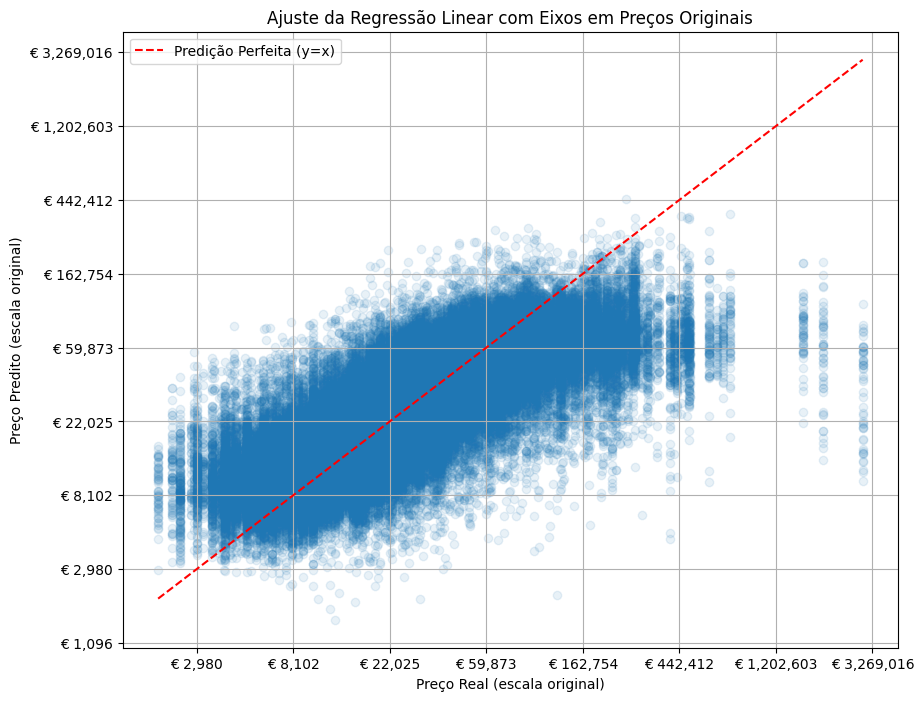

In [48]:


# 4. Inicializar e Treinar o Modelo
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, Y_train_log)

# 5. Avaliação Interna (no conjunto de treino)
Y_train_pred_log = linear_model.predict(X_train_scaled)


# 7. Plotagem Correta
# A plotagem é feita no espaço log-transformado para visualizar a linearidade.
plt.figure(figsize=(10, 8))
plt.scatter(Y_train_log, Y_train_pred_log, alpha=0.1)

# 2. Definir a função de formatação dos eixos
# O formatter recebe o valor logarítmico (x) e retorna o valor original (exp(x) - 1) formatado
def original_price_formatter(x, pos):
    # np.expm1(x) é o mesmo que np.exp(x) - 1
    return f'€ {np.expm1(x):,.0f}'

# 3. Aplicar o Formatter aos eixos X e Y
formatter = FuncFormatter(original_price_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Linha de predição perfeita (y=x)
lims = [Y_train_log.min(), Y_train_log.max()]
plt.plot(lims, lims, color='red', linestyle='--', label='Predição Perfeita (y=x)')

plt.xlabel('Preço Real (escala original)')
plt.ylabel('Preço Predito (escala original)')
plt.title('Ajuste da Regressão Linear com Eixos em Preços Originais')
plt.legend()
plt.grid(True)
plt.show()

# K-Nearest Neighbors (KNN)

In [26]:
knn = KNeighborsRegressor(
    algorithm='auto'
)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 15, 25],
    'weights': ['distance']
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, Y_train_log)






Fitting 5 folds for each of 7 candidates, totalling 35 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",KNeighborsRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'n_neighbors': [1, 3, ...], 'weights': ['distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;

In [ ]:
best_knn = grid.best_estimator_

print("Melhor k encontrado:", grid.best_params_)
print("Melhor RMSE (log):", (-grid.best_score_) ** 0.5)

Y_pred_knn_log = best_knn.predict(X_test_scaled)



Melhor k encontrado: {'n_neighbors': 25, 'weights': 'distance'}
Melhor RMSE (log): 0.5508259179144246


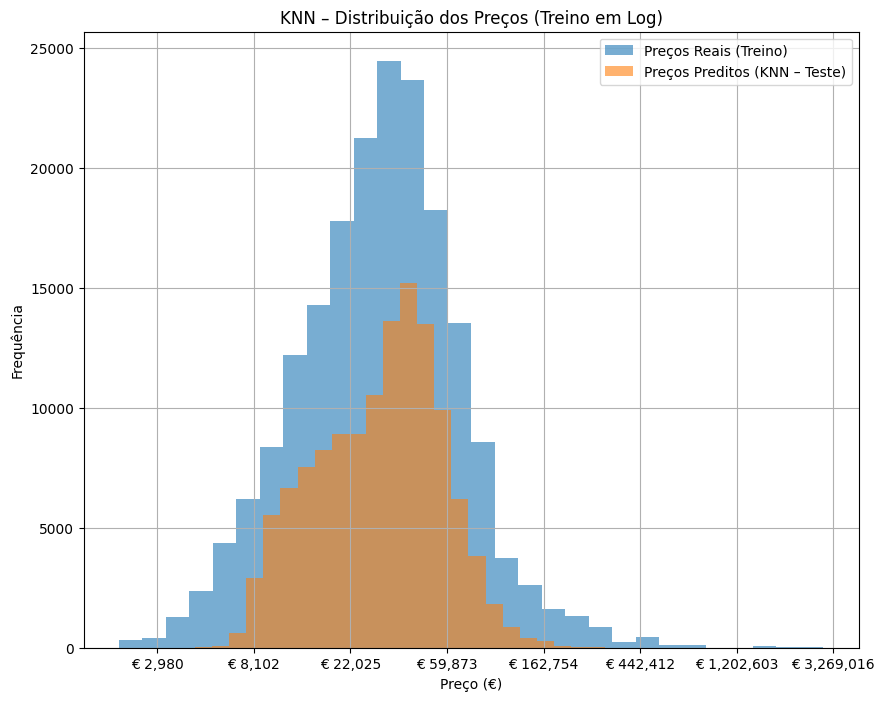

In [28]:
plt.figure(figsize=(10, 8))

plt.hist(
    Y_train_log,
    bins=30,
    alpha=0.6,
    label='Preços Reais (Treino)'
)

plt.hist(
    Y_pred_knn_log,
    bins=30,
    alpha=0.6,
    label='Preços Preditos (KNN – Teste)'
)

def euro_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(euro_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('KNN – Distribuição dos Preços (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()



# Random Forest

In [ ]:
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_scaled, Y_train_log)

Y_pred_rf_log = rf.predict(X_test_scaled)




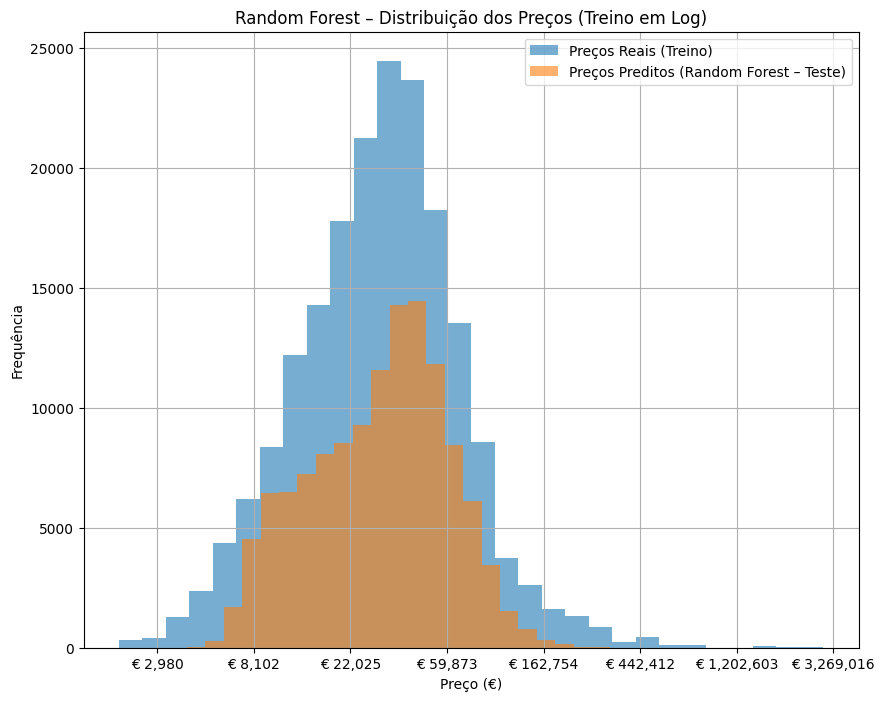

In [25]:
plt.figure(figsize=(10, 8))

plt.hist(
    Y_train_log,
    bins=30,
    alpha=0.6,
    label='Preços Reais (Treino)'
)

plt.hist(
    Y_pred_rf_log,
    bins=30,
    alpha=0.6,
    label='Preços Preditos (Random Forest – Teste)'
)

def euro_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(euro_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('Random Forest – Distribuição dos Preços (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()


# XGBoost Regressor

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train_scaled, Y_train_log)

Y_pred_xgb_log = xgb_model.predict(X_test_scaled)



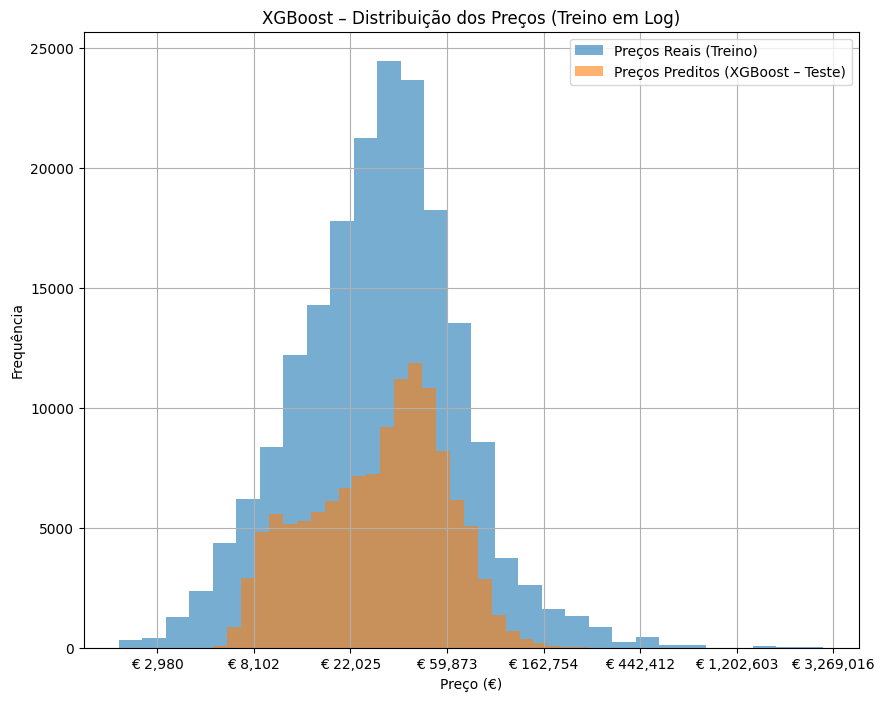

In [23]:
plt.figure(figsize=(10, 8))

plt.hist(
    Y_train_log,
    bins=30,
    alpha=0.6,
    label='Preços Reais (Treino)'
)

plt.hist(
    Y_pred_xgb_log,
    bins=30,
    alpha=0.6,
    label='Preços Preditos (XGBoost – Teste)'
)

def euro_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(euro_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('XGBoost – Distribuição dos Preços (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()


# Árvores de Decisão

In [18]:


# Inicializar o modelo
tree_model = DecisionTreeRegressor(
    max_depth=6,          # evita overfitting
    min_samples_leaf=50,  # folhas mais estáveis
    random_state=42
)

# Treinar no target log-transformado
tree_model.fit(X_train_scaled, Y_train_log)


,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_lea

In [ ]:
Y_train_pred_log = tree_model.predict(X_train_scaled)



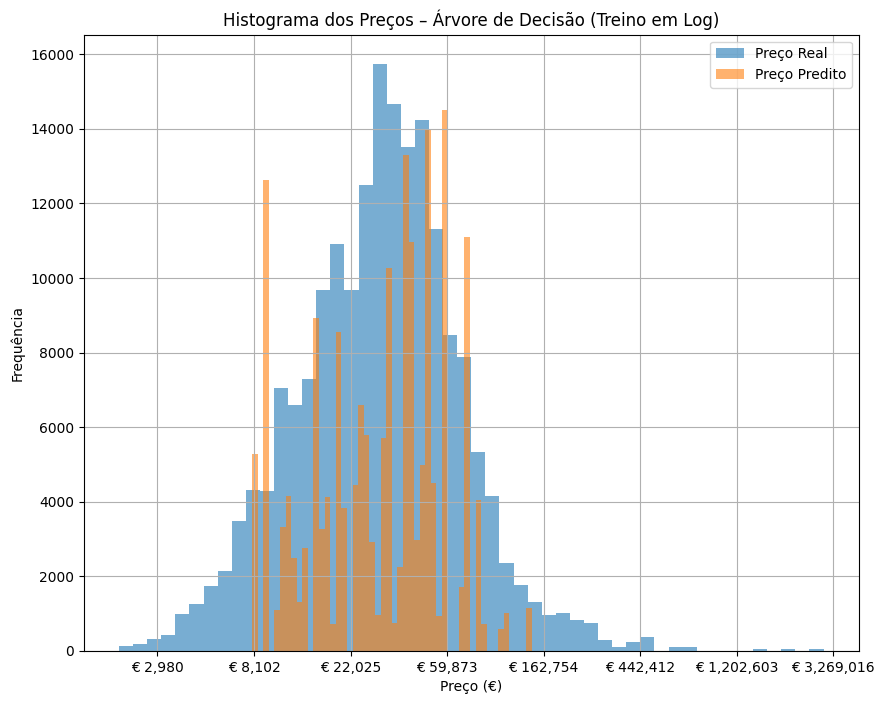

In [21]:
plt.figure(figsize=(10, 8))

plt.hist(Y_train_log, bins=50, alpha=0.6, label='Preço Real')
plt.hist(Y_train_pred_log, bins=50, alpha=0.6, label='Preço Predito')

def original_price_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(original_price_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('Histograma dos Preços – Árvore de Decisão (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()


# Redes Neurais 

In [ ]:
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 2 camadas escondidas
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

nn_model.fit(X_train_scaled, Y_train_log)

Y_pred_nn_log = nn_model.predict(X_test_scaled)




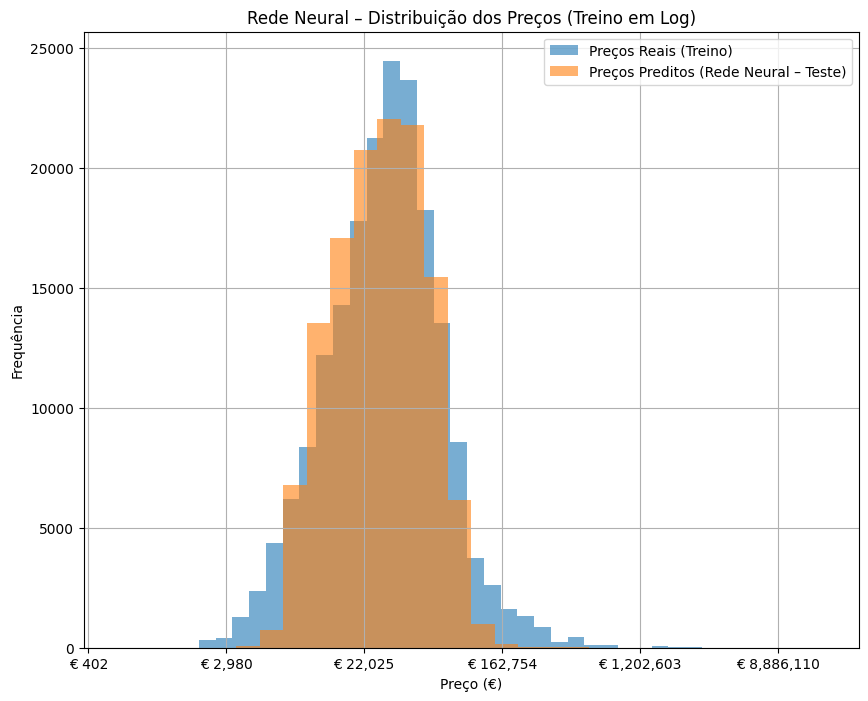

In [46]:
plt.figure(figsize=(10, 8))

plt.hist(
    Y_train_log,
    bins=30,
    alpha=0.6,
    label='Preços Reais (Treino)'
)

plt.hist(
    Y_pred_nn_log,
    bins=30,
    alpha=0.6,
    label='Preços Preditos (Rede Neural – Teste)'
)

def euro_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(euro_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('Rede Neural – Distribuição dos Preços (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()


# Support Vector Machines (SVM)

In [ ]:
svm_model = SVR(
    kernel='rbf',
    C=100,
    gamma='scale',
    epsilon=0.1
)

svm_model.fit(X_train_scaled, Y_train_log)

Y_pred_svm_log = svm_model.predict(X_test_scaled)

Y_pred_svm_original = np.expm1(Y_pred_svm_log)



In [ ]:
plt.figure(figsize=(10, 8))



plt.hist(Y_train_log, bins=30, alpha=0.6, label='Preços Reais (Treino)')
plt.hist(Y_pred_svm_log, bins=30, alpha=0.6, label='Preços Preditos (SVM – Teste)')

def euro_formatter(x, pos):
    return f'€ {np.expm1(x):,.0f}'

formatter = FuncFormatter(euro_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Preço (€)')
plt.ylabel('Frequência')
plt.title('SVM – Distribuição dos Preços (Treino em Log)')
plt.legend()
plt.grid(True)
plt.show()


# CSV Creation

# Linear Regression

In [ ]:
# 3. Fazer a Predição (no espaço logarítmico)
Y_test_pred_log = linear_model.predict(X_test_scaled)

# 4. Reverter a Transformação Logarítmica para Preços Originais
Y_test_pred_original = np.expm1(Y_test_pred_log)

# 5. Criar o DataFrame de Submissão
submission = pd.DataFrame({
    'id': test['id'],  # Usar o 'id' original do arquivo test.csv
    'price': Y_test_pred_original
})

submission.to_csv('submission_liner_regression.csv', index=False)

# K-Nearest Neighbors (KNN)

In [33]:
# Submissão
submission = pd.DataFrame({
    'id': test['id'],
    'price': Y_test_pred_original
})

submission.to_csv('submission_knn_optimized.csv', index=False)

# Random Forest

In [34]:
# 3. Fazer a Predição (no espaço logarítmico)

Y_pred_rf = rf.predict(X_test_scaled)

# 4. Reverter a Transformação Logarítmica para Preços Originais

Y_pred_rf_original = np.expm1(Y_pred_rf)

# 5. Criar o DataFrame de Submissão
submission = pd.DataFrame({
    'id': test['id'],  # Usar o 'id' original do arquivo test.csv
    'price': Y_pred_rf_original
})

submission.to_csv('submission_RandomForest.csv', index=False)

# XGBoost Regressor

In [35]:
# 3. Fazer a Predição (no espaço logarítmico)

Y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4. Reverter a Transformação Logarítmica para Preços Originais

Y_pred_xgb_original = np.expm1(Y_pred_xgb)

# 5. Criar o DataFrame de Submissão
submission = pd.DataFrame({
    'id': test['id'],  # Usar o 'id' original do arquivo test.csv
    'price': Y_pred_xgb_original
})

submission.to_csv('submission_XGBoost.csv', index=False)

# Árvores de decisão 

In [40]:
Y_test_pred_log = tree_model.predict(X_test_scaled)

Y_test_pred_original = np.expm1(Y_test_pred_log)

submission = pd.DataFrame({
    'id': test['id'],      # id do test.csv
    'price': Y_test_pred_original
})

submission.to_csv('submission_tree_model.csv', index=False)



# Redes Neurais 

In [47]:
# 3. Fazer a Predição (no espaço logarítmico)
Y_pred_nn_log = nn_model.predict(X_test_scaled)

# 4. Reverter a Transformação Logarítmica para Preços Originais
Y_pred_nn_original = np.expm1(Y_pred_nn_log)

# 5. Criar o DataFrame de Submissão
submission = pd.DataFrame({
    'id': test['id'],  # Usar o 'id' original do arquivo test.csv
    'price': Y_pred_nn_original
})

submission.to_csv('submission_neural_network.csv', index=False)

# Support Vector Machines (SVM)